In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from matplotlib import rcParams
from ForceMapping import forceMapping as fm
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)
from itertools import product

#### load the data

In [10]:
period = 140

In [11]:
# keep all limbs has same amount of abnormal samples


data_normal = np.loadtxt('data_for_train.csv', delimiter=',')
RF_ab = np.load('RF_limb.npy')
LF_ab = np.load('LF_limb.npy')
LH_ab = np.load('LH_limb.npy')
RH_ab = np.load('RH_limb.npy')[period*3:,:]

np.random.seed(42) 
# data for normal
select_id_normal = np.arange(int(data_normal.shape[0]/period))
np.random.shuffle(select_id_normal)
data_normal = generate_data_set(select_id_normal, data_normal)
# data for RF
select_id_RF = np.arange(int(RF_ab.shape[0]/period))
np.random.shuffle(select_id_RF)
RF_ab = generate_data_set(select_id_RF[:30], RF_ab)
# data for LF
select_id_LF = np.arange(int(LF_ab.shape[0]/period))
np.random.shuffle(select_id_LF)
LF_ab = generate_data_set(select_id_LF[:30], LF_ab)
# data for LH
select_id_LH = np.arange(int(LH_ab.shape[0]/period))
np.random.shuffle(select_id_LH)
LH_ab = generate_data_set(select_id_LH[:30], LH_ab)
# data for RH
select_id_RH = np.arange(int(RH_ab.shape[0]/period))
np.random.shuffle(select_id_RH)
RH_ab = generate_data_set(select_id_RH[:30], RH_ab)


#### Prepare the training set

In [12]:
data_for_train = np.vstack((data_normal, RF_ab, LF_ab, LH_ab,RH_ab))
scaler = MinMaxScaler(feature_range=(-1, 1))
data_for_train[:,16:20] = scaler.fit_transform(data_for_train[:,16:20].reshape(-1,1)).reshape(-1,4)

In [266]:
np.save('data_for_train.npy', data_for_train)

In [265]:
data_for_train.shape

(23940, 40)

### Prepare the train, val, test data

In [14]:
# Example usage
train_ad, val_ad, test_ad = generate_split(0, 50)
train_lose, val_lose, test_lose = generate_split(51, 171)

train_id =  np.concatenate((train_ad,train_lose))
val_id = np.concatenate((val_ad,val_lose))
test_id = np.concatenate((test_ad,test_lose))

np.random.seed(42) 
np.random.shuffle(train_id)
np.random.shuffle(test_id)



In [15]:
train_set, val_set, test_set = generate_data_sets(train_id, val_id, test_id, data_for_train)

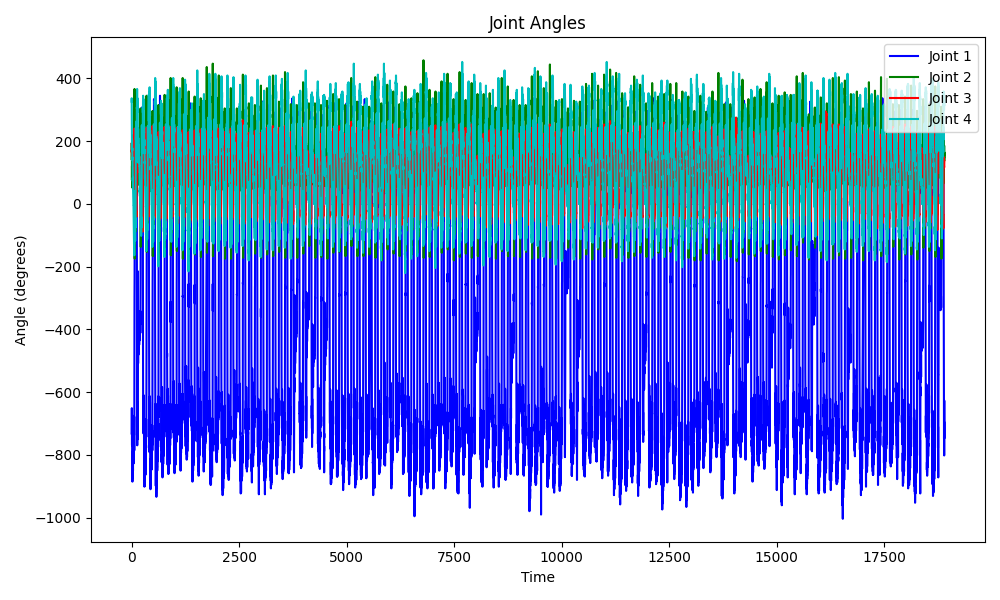

In [16]:
plt.close('all')
plot_joint_angles(train_set[:,20:24])

#### Optimize the esn

In [17]:
# Your data
# train_inputs, train_targets, val_inputs, val_targets
# Make sure they're numpy arrays of appropriate shapes

# Your dataset
# train_inputs, train_targets, val_inputs, val_targets
# Ensure they are NumPy arrays

# Grid ranges
spectral_radius_range = [0.8, 0.85, 0.9, 0.95]
sparsity_range = [0.1, 0.2, 0.3, 0.4]
leak_rate_range = [0.3, 0.6, 0.9]
reservoir_size_range = [60, 80, 100]

train_inputs = train_set[:,16:20]
train_targets = train_set[:,32:34]
val_inputs = val_set[:,16:20]
val_targets = val_set[:,32:34]

best_params = None
lowest_mse = float('inf')

for spectral_radius, sparsity, leak_rate, reservoir_size in product(
    spectral_radius_range, sparsity_range, leak_rate_range, reservoir_size_range
):
    esn = ESN(
        input_size=4,
        reservoir_size=reservoir_size,
        output_size=2,
        spectral_radius=spectral_radius,
        sparsity=sparsity,
        leak_rate=leak_rate,
        seed=42
    )

    esn.fit(train_inputs, train_targets)
    predictions = esn.predict(val_inputs)
    # mse in y axis direction
    mse_per_col = mean_squared_error(val_targets[:,1], predictions[:,1], multioutput='raw_values')
    # mse in z and y axis directions
    mse_in_total = mean_squared_error(val_targets, predictions, )
    total_mse = np.mean(mse_per_col)

    print(f"RS={spectral_radius}, Sparsity={sparsity}, Leak={leak_rate}, Size={reservoir_size}, MSE_in_Y={total_mse:.4f}, MSE_in_total={np.mean(mse_in_total):.4f}")

    if total_mse < lowest_mse:
        lowest_mse = total_mse
        best_params = (spectral_radius, sparsity, leak_rate, reservoir_size)

print("\nBest Parameters:")
print(f"Spectral Radius = {best_params[0]}")
print(f"Sparsity = {best_params[1]}")
print(f"Leak Rate = {best_params[2]}")
print(f"Reservoir Size = {best_params[3]}")
print(f"Validation MSE = {lowest_mse:.4f}")

RS=0.8, Sparsity=0.1, Leak=0.3, Size=60, MSE_in_Y=0.0194, MSE_in_total=0.1417
RS=0.8, Sparsity=0.1, Leak=0.3, Size=80, MSE_in_Y=0.0172, MSE_in_total=0.1299
RS=0.8, Sparsity=0.1, Leak=0.3, Size=100, MSE_in_Y=0.0153, MSE_in_total=0.1314
RS=0.8, Sparsity=0.1, Leak=0.6, Size=60, MSE_in_Y=0.0171, MSE_in_total=0.1489
RS=0.8, Sparsity=0.1, Leak=0.6, Size=80, MSE_in_Y=0.0155, MSE_in_total=0.1365
RS=0.8, Sparsity=0.1, Leak=0.6, Size=100, MSE_in_Y=0.0144, MSE_in_total=0.1336
RS=0.8, Sparsity=0.1, Leak=0.9, Size=60, MSE_in_Y=0.0180, MSE_in_total=0.1590
RS=0.8, Sparsity=0.1, Leak=0.9, Size=80, MSE_in_Y=0.0158, MSE_in_total=0.1479
RS=0.8, Sparsity=0.1, Leak=0.9, Size=100, MSE_in_Y=0.0160, MSE_in_total=0.1440
RS=0.8, Sparsity=0.2, Leak=0.3, Size=60, MSE_in_Y=0.0178, MSE_in_total=0.1540
RS=0.8, Sparsity=0.2, Leak=0.3, Size=80, MSE_in_Y=0.0169, MSE_in_total=0.1450
RS=0.8, Sparsity=0.2, Leak=0.3, Size=100, MSE_in_Y=0.0167, MSE_in_total=0.1280
RS=0.8, Sparsity=0.2, Leak=0.6, Size=60, MSE_in_Y=0.0163, MS

### Update the optimization to reservior size related 

In [23]:
# Extract input/target features




train_inputs = train_set[:, 16:20]
train_targets = train_set[:, 32:34]
val_inputs = val_set[:, 16:20]
val_targets = val_set[:, 32:34]



# Storage: one row per reservoir size, columns = [MSE_Y, spectral_radius, sparsity, leak_rate]
best_per_size = {}

for spectral_radius, sparsity, leak_rate, reservoir_size in product(
    spectral_radius_range, sparsity_range, leak_rate_range, reservoir_size_range
):
    esn = ESN(
        input_size=4,
        reservoir_size=reservoir_size,
        output_size=2,
        spectral_radius=spectral_radius,
        sparsity=sparsity,
        leak_rate=leak_rate,
        seed=42
    )

    esn.fit(train_inputs, train_targets)
    predictions = esn.predict(val_inputs)

    mse_y = mean_squared_error(val_targets[:, 1], predictions[:, 1])

    # If it's the first time or current MSE is better, update record
    if (reservoir_size not in best_per_size) or (mse_y < best_per_size[reservoir_size][0]):
        best_per_size[reservoir_size] = [mse_y, spectral_radius, sparsity, leak_rate]

# Convert to matrix
result_matrix = []
for res_size in sorted(best_per_size.keys()):
    row = [res_size] + best_per_size[res_size]  # [reservoir_size, mse_y, sr, sparsity, leak]
    result_matrix.append(row)

result_matrix = np.array(result_matrix)

# Print the results
print("\nReservoir Size | Best MSE_Y | Spectral Radius | Sparsity | Leak Rate")
for row in result_matrix:
    print(f"{int(row[0]):14} | {row[1]:10.4f} | {row[2]:15} | {row[3]:8} | {row[4]:9}")


Reservoir Size | Best MSE_Y | Spectral Radius | Sparsity | Leak Rate
            60 |     0.0161 |             0.9 |      0.2 |       0.6
            80 |     0.0148 |             0.8 |      0.3 |       0.6
           100 |     0.0143 |             0.8 |      0.2 |       0.6
           120 |     0.0138 |            0.85 |      0.4 |       0.3
           140 |     0.0137 |             0.8 |      0.1 |       0.6
           160 |     0.0134 |             0.8 |      0.4 |       0.6


In [18]:
# input_size, reservoir_size, output_size, spectral_radius=0.95, sparsity=0.1, leak_rate=0.9, seed=42
esn_optimal = ESN(4, 100, 2, 0.8, 0.2, 0.6)
esn_optimal.fit(train_set[:,16:20], train_set[:,32:34])


In [19]:
grf_predicted = esn_optimal.predict(test_set[:,16:20])

In [264]:
import pickle

# Save
with open('RF_limb.pkl', 'wb') as f:
    pickle.dump(esn_optimal, f)

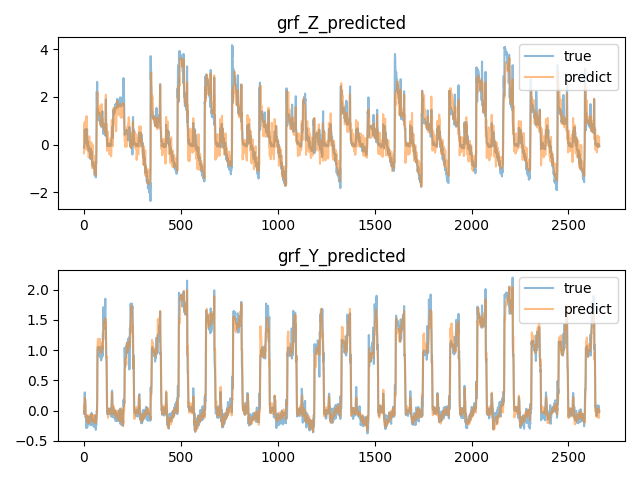

In [20]:
plt.close('all')
plt.subplot(2,1,1)
plt.plot(test_set[:,32], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:,0], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Z_predicted')

plt.subplot(2,1,2)
plt.plot(test_set[:,33], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:,1], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Y_predicted')
plt.tight_layout()

In [2]:
def columnwise_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2, axis=0)

In [3]:
def generate_split(start, end):
    # Generate the ID list from start to end (inclusive)
    ids = np.arange(start, end + 1)
    
    # Shuffle the ID list randomly
    np.random.shuffle(ids)
    
    # Calculate the split sizes
    total_size = len(ids)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size  # Remainder goes to the test set
    
    # Split the IDs
    train_set = ids[:train_size]
    val_set = ids[train_size:train_size + val_size]
    test_set = ids[train_size + val_size:]
    
    return train_set, val_set, test_set

In [4]:
class ESN:
    def __init__(self, input_size, reservoir_size, output_size, 
                 spectral_radius=0.95, sparsity=0.1, leak_rate=0.9, seed=42):
        if seed is not None:
            np.random.seed(seed)

        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.leak_rate = leak_rate

        # Input weights
        self.Win = np.random.uniform(-1, 1, (reservoir_size, input_size))

        # Reservoir weights
        W = np.random.rand(reservoir_size, reservoir_size) - 0.5
        mask = np.random.rand(*W.shape) < sparsity
        W *= mask  # sparsify
        eigvals = np.max(np.abs(np.linalg.eigvals(W)))
        self.Wres = W * (spectral_radius / eigvals)

        # Output weights (trained later)
        self.Wout = None

        self.state = np.zeros((reservoir_size,))

    def _update_state(self, u):
        pre_activation = np.dot(self.Win, u) + np.dot(self.Wres, self.state)
        new_state = np.tanh(pre_activation)
        self.state = (1 - self.leak_rate) * self.state + self.leak_rate * new_state
        return self.state

    def fit(self, inputs, targets, washout=50, ridge_lambda=1e-6):
        states = []
        for u in inputs:
            state = self._update_state(u)
            states.append(state)

        states = np.array(states)
        states_washed = states[washout:]
        targets_washed = targets[washout:]

        # Add bias term
        extended_states = np.hstack([states_washed, np.ones((states_washed.shape[0], 1))])
        
        # Ridge regression
        self.Wout = np.dot(np.linalg.pinv(extended_states), targets_washed)

    def predict(self, inputs):
        outputs = []
        for u in inputs:
            state = self._update_state(u)
            extended_state = np.concatenate([state, [1]])  # Add bias
            y = np.dot(extended_state, self.Wout)
            outputs.append(y)
        return np.array(outputs)

In [5]:
def generate_data_set(train_id, data_for_train, period=140):
    train_set = []
    for i in train_id:
        train_set.append(data_for_train[period * i: period * (i + 1), :])
    return np.vstack(train_set)

In [6]:
def generate_data_sets(train_id, val_id, test_id, data_for_train, period=140):
    # Initialize empty lists to hold the subsets
    train_set = []
    val_set = []
    test_set = []

    # Populate train_set
    for i in train_id:
        train_set.append(data_for_train[period * i: period * (i + 1), :])

    # Populate val_set
    for i in val_id:
        val_set.append(data_for_train[period * i: period * (i + 1), :])

    # Populate test_set
    for i in test_id:
        test_set.append(data_for_train[period * i: period * (i + 1), :])

    return np.vstack(train_set), np.vstack(val_set), np.vstack(test_set)

In [7]:
def plot_joint_angles(joint_angles, title="Joint Angles", xlabel="Time", ylabel="Angle (degrees)"):
    """
    绘制四关节角度信号
    
    参数:
        joint_angles: 形状为(n,4)的numpy数组，包含四个关节的角度数据
        title: 图表标题 (默认: "Joint Angles")
        xlabel: x轴标签 (默认: "Time")
        ylabel: y轴标签 (默认: "Angle (degrees)")
    """
    # 检查输入数据
    if not isinstance(joint_angles, np.ndarray) or joint_angles.shape[1] != 4:
        raise ValueError("输入数据必须是形状为(n,4)的numpy数组")
    
    # 创建图形和轴
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 时间轴 (假设是等间隔采样)
    time = np.arange(joint_angles.shape[0])
    
    # 为每个关节绘制曲线
    joints = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4']
    colors = ['b', 'g', 'r', 'c']  # 不同颜色区分关节
    
    for i in range(4):
        ax.plot(time, joint_angles[:, i], 
                color=colors[i], 
                label=joints[i],
                linewidth=1.5)
    
    # 添加图例和标签
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # # 添加网格
    # ax.grid(True, linestyle='--', alpha=0.6)
    
    # 自动调整布局
    plt.tight_layout()
    
    # 显示图形

In [8]:
def plot_leg_joints(data, joint_label='关节', title='四足机器人关节数据', save_path=None):
    """
    绘制四足机器人关节数据的2x2子图
    
    参数:
        data: numpy数组，形状为[n,16]，包含四个腿的关节数据
        joint_label: 关节标签名称 (默认: '关节')
        title: 图表标题 (默认: '四足机器人关节数据')
        save_path: 图片保存路径 (可选)，如'output.png'
    """
    # 设置中文字体为宋体
    plt.rcParams['font.sans-serif'] = ['SimSun']  # 或者使用 'STSong'
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    
    # 检查数据形状
    if data.shape[1] != 16:
        raise ValueError("输入数据的列数应为16 (4腿×4关节)")
    
    # 创建2x2的子图布局
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)

    # 定义每个腿的标签和颜色
    leg_names = ['腿1', '腿2', '腿3', '腿4']
    joint_names = [f'{joint_label}{i+1}' for i in range(4)]  # 使用输入的关节标签
    colors = ['r', 'g', 'b', 'm']  # 每种关节的颜色
    line_styles = ['-', '--', ':', '-.']  # 可选的线型

    # 绘制每个腿的数据
    for leg_idx in range(4):
        # 确定子图位置
        if leg_idx == 0:  # Leg1 -> (0,1)
            ax = axs[0, 1]
        elif leg_idx == 1:  # Leg2 -> (0,0)
            ax = axs[0, 0]
        elif leg_idx == 2:  # Leg3 -> (1,0)
            ax = axs[1, 0]
        else:  # Leg4 -> (1,1)
            ax = axs[1, 1]
        
        # 提取当前腿的数据 (4个关节)
        leg_data = data[:, leg_idx*4 : (leg_idx+1)*4]
        
        # 绘制每个关节的数据
        for joint_idx in range(4):
            ax.plot(leg_data[:, joint_idx], 
                    color=colors[joint_idx],
                    linestyle=line_styles[joint_idx],
                    linewidth=1.5,
                    label=joint_names[joint_idx])
        
        # 设置子图标题和标签
        ax.set_title(f'{leg_names[leg_idx]}{joint_label}数据')
        ax.set_xlabel('时间点')
        ax.set_ylabel(f'{joint_label}值(rad)')
        ax.legend(loc='upper right')
        # ax.grid(True, linestyle='--', alpha=0.6)

    # 调整子图间距
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    # 保存或显示图形
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图表已保存至: {save_path}")
    plt.show()

In [9]:
def plot_force_sensors(data, title='力传感器数据', save_path=None):
    """
    绘制四个力传感器的Y/Z方向力学信号的2x2子图
    
    参数:
        data: numpy数组，形状为[n,16]，数据排列顺序为[FS6_Y, FS6_Z, FS2_Y, FS2_Z, FS4_Y, FS4_Z, FS3_Y, FS3_Z, ...]
        title: 图表标题 (默认: '力传感器数据')
        save_path: 图片保存路径 (可选)
    """
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimSun']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 检查数据形状
    if data.shape[1] != 8:
        raise ValueError("输入数据列数应为86 (4传感器×2方向)")
    
    # 创建2x2子图
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(title, fontsize=16)

    # 传感器配置 (名称, 子图位置, 数据列索引)
    sensor_config = [
        ('FS2', axs[0, 1], (0, 1)),   # 右上: FS2 (Y:0列, Z:1列)
        ('FS6', axs[0, 0], (2, 3)),   # 右上: FS6 (Y:2列, Z:3列)
        ('FS4', axs[1, 0], (4, 5)),   # 左下: FS4 (Y:4列, Z:5列)
        ('FS3', axs[1, 1], (6, 7))    # 右下: FS3 (Y:6列, Z:7列)
    ]

    # 绘制每个传感器的数据
    for name, ax, (y_col, z_col) in sensor_config:
        y_data = data[:, y_col]
        z_data = data[:, z_col]
        time = np.arange(len(y_data))
        
        ax.plot(time, y_data, 'b-', label='Z方向力')
        ax.plot(time, z_data, 'r-', label='Y方向力')
        ax.set_title(name)
        ax.set_xlabel('时间点')
        ax.set_ylabel('力(N)')
        ax.set_ylim(-4, 4)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    # 调整布局
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    # 保存或显示
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图表已保存至: {save_path}")
    
    plt.show()